In [25]:
import cv2 as cv
from matplotlib import pyplot as plt
import numpy as np
from PIL import ImageFont, ImageDraw, Image

In [6]:
def debug_imshow(image):
  fig = plt.figure(figsize=(4, 3), dpi=100)
  plt.imshow(cv.cvtColor(image, cv.COLOR_BGR2RGB))
  plt.show()

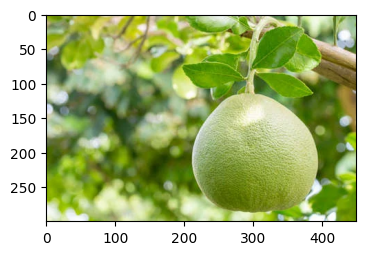

In [48]:
image_path = 'static/test8.webp'
image = cv.imread(image_path)
debug_imshow(image)



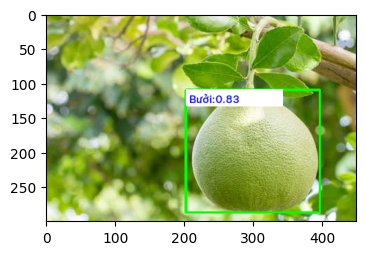

True

In [50]:
fruit_net = cv.dnn.readNet('./models/fruit.onnx')
WIDTH_INPUT = 640
HEIGHT_INPUT  = 640
SCORE_THRESHOLD = 0.5
NMS_THRESHOLD = 0.45
CONFIDENCE_THRESHOLD = 0.45
CLASSES = ["Bưởi", "Cam", "Cóc", "Khế", "Mít"]

image_input = image.copy()
blob = cv.dnn.blobFromImage(image_input, 1/255,  (WIDTH_INPUT, HEIGHT_INPUT), [0,0,0], 1, crop=False)
fruit_net.setInput(blob)
outputs = fruit_net.forward(fruit_net.getUnconnectedOutLayersNames())

class_ids = []
confidences = []
boxes = []
rows = outputs[0].shape[1]
image_height, image_width = image_input.shape[:2]
x_factor = image_width / WIDTH_INPUT
y_factor =  image_height / HEIGHT_INPUT

for r in range(rows):
  row = outputs[0][0][r]
  confidence = row[4]
  if confidence >= CONFIDENCE_THRESHOLD:
    classes_scores = row[5:]
    class_id = np.argmax(classes_scores)
    if (classes_scores[class_id] > SCORE_THRESHOLD):
      confidences.append(confidence)
      class_ids.append(class_id)
      cx, cy, w, h = row[0], row[1], row[2], row[3]
      left = int((cx - w/2) * x_factor)
      top = int((cy - h/2) * y_factor)
      width = int(w * x_factor)
      height = int(h * y_factor)
      box = np.array([left, top, width, height])
      boxes.append(box)

  indices = cv.dnn.NMSBoxes(boxes, confidences, CONFIDENCE_THRESHOLD, NMS_THRESHOLD)
  for i in indices:
    box = boxes[i]
    left = box[0]
    top = box[1]
    width = box[2]
    height = box[3]             
    cv.rectangle(image_input, (left, top), (left + width, top + height), (0, 255, 0), 2)
    label = "{}:{:.2f}".format(CLASSES[class_ids[i]], confidences[i])             
    text_size = cv.getTextSize(label, cv.FONT_HERSHEY_SIMPLEX, 0.7, 1)
    dim, baseline = text_size[0], text_size[1]
    cv.rectangle(image_input, (left, top), (left + dim[0], top + dim[1] + baseline), (255,255,255), cv.FILLED)
    
    fontpath = "static/pro.ttf"
    font = ImageFont.truetype(fontpath, 15)
    img_pil = Image.fromarray(image_input)
    draw = ImageDraw.Draw(img_pil)
    draw.text((left+5, top+5), label, font = font, fill = (255, 0, 0))
    image_input = np.array(img_pil)

debug_imshow(image_input)
cv.imwrite('out.jpg', image_input)
